# 🛍️ SmartCart Starter Notebook
This notebook will guide you through your group project on collaborative filtering and association rule mining for an e-commerce recommender system.

## 📥 Part 1: Data Preprocessing
Steps:
- Load `ecommerce_user_data.csv` and `product_details.csv`
- Merge data if necessary
- Create user-item matrix
- Fill missing ratings with 0
- Group user behavior by category

In [28]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
import networkx as nx  
from adjustText import adjust_text

In [30]:
# Load data
user_data = pd.read_csv('./data/ecommerce_user_data.csv')
product_data = pd.read_csv('./data/product_details.csv')

print(user_data.head())
print(product_data.head())

  UserID ProductID  Rating   Timestamp  Category
0   U000     P0009       5  2024-09-08     Books
1   U000     P0020       1  2024-09-02      Home
2   U000     P0012       4  2024-10-18     Books
3   U000     P0013       1  2024-09-18  Clothing
4   U000     P0070       4  2024-09-16      Toys
  ProductID      ProductName     Category
0     P0000      Toys Item 0     Clothing
1     P0001  Clothing Item 1  Electronics
2     P0002     Books Item 2  Electronics
3     P0003  Clothing Item 3  Electronics
4     P0004  Clothing Item 4  Electronics


In [3]:
# Create user-item matrix
user_item_matrix = user_data.pivot_table(index='UserID', columns='ProductID', values='Rating')
user_item_matrix_filled = user_item_matrix.fillna(0)
user_item_matrix_filled.head()

ProductID,P0000,P0001,P0002,P0003,P0004,P0005,P0006,P0007,P0008,P0009,...,P0090,P0091,P0092,P0093,P0094,P0095,P0096,P0097,P0098,P0099
UserID,,,,,,,,,,,,,,,,,,,,,
U000,0.0,0.0,0.0,3.0,0.0,5.0,0.0,3.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U001,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
U002,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
U004,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0


In [4]:
# Aggregate user behavior by category
user_category_agg = user_data.groupby(['UserID', 'Category']).agg({'Rating': ['count', 'mean']}).reset_index()
user_category_agg.columns = ['UserID', 'Category', 'TotalInteractions', 'AverageRating']
user_category_agg.head()

,UserID,Category,TotalInteractions,AverageRating
0,U000,Books,6,3.666667
1,U000,Clothing,3,1.666667
2,U000,Electronics,3,3.666667
3,U000,Home,2,1.000000
4,U000,Toys,6,3.500000


## 🤝 Part 2: User-Based Collaborative Filtering
Steps:
- Use cosine similarity to compare users
- Recommend top-N products based on similar users
- Evaluate with Precision@K and Coverage

In [5]:
# Compute the mean for each user, ignoring zeros
user_means = user_item_matrix_filled.replace(0, np.nan).mean(axis=1)

# Subtract the mean only for nonzero values
def mean_subtract(row, mean):
    return [val - mean if val != 0 else 0 for val in row]

user_item_matrix_mean_subtracted = user_item_matrix_filled.apply(lambda row: mean_subtract(row, user_means[row.name]), axis=1)

# Convert back to DataFrame
user_item_matrix_mean_subtracted = pd.DataFrame(user_item_matrix_mean_subtracted.tolist(), index=user_item_matrix_filled.index, columns=user_item_matrix_filled.columns)

In [6]:
# Compute cosine similarity
similarity_matrix = cosine_similarity(user_item_matrix_mean_subtracted)
similarity_df = pd.DataFrame(similarity_matrix, 
                             index=user_item_matrix_mean_subtracted.index, 
                             columns=user_item_matrix_mean_subtracted.index)
similarity_df.head()

UserID,U000,U001,U002,U003,U004,U005,U006,U007,U008,U009,...,U040,U041,U042,U043,U044,U045,U046,U047,U048,U049
UserID,,,,,,,,,,,,,,,,,,,,,
U000,1.000000,0.067035,0.179653,0.098581,-0.070840,0.145208,0.042538,-0.057723,-0.029465,0.104067,...,-0.085485,-0.123940,0.129935,0.115992,-0.016100,0.034953,-0.139800,-0.002088,0.000000,0.051208
U001,0.067035,1.000000,0.189719,0.000000,-0.046066,0.113840,0.000000,-0.027632,-0.210209,-0.005819,...,-0.183926,-0.042229,0.000000,0.142616,0.000000,0.000000,0.015644,-0.154582,0.000000,0.000000
U002,0.179653,0.189719,1.000000,-0.003939,-0.121584,-0.126329,-0.034385,-0.032835,0.000000,0.084316,...,-0.111363,0.000000,0.184211,0.000000,-0.041211,0.088152,0.014606,-0.070559,0.095782,0.000000
U003,0.098581,0.000000,-0.003939,1.000000,0.007440,-0.033226,0.015284,0.000000,-0.008745,0.049410,...,0.045515,0.000000,0.000000,-0.180719,0.073014,0.000000,-0.016231,-0.049346,0.254235,-0.002769
U004,-0.070840,-0.046066,-0.121584,0.007440,1.000000,0.062863,-0.062348,0.046070,-0.091419,0.016623,...,-0.115801,-0.053617,-0.169133,0.026635,-0.107558,-0.096057,-0.079316,-0.090866,0.121400,0.058978


In [7]:
# Create recommendation function
# Find most similar user, recommend products they rated highly that target user hasn’t rated
"""
Step 1: Find the top N similar users, using the cosine similarity matrix
"""
def get_top_similar_users(user_id, similarity_df, top_n):
    # drop will remove the column user_id from the row similarity_df[user_id] to avoid self-matching
    # sort_values will sort in DESC order
    # head will take the top_n rows
    similar_users = similarity_df[user_id].drop(user_id).sort_values(ascending=False).head(top_n)
    
    # convert similar_users into a list of UserID (ex: ['U028', 'U010', 'U018', 'U009', 'U029'])
    return similar_users.index.tolist()

In [8]:
"""
Step 2: Recommend products based on the top N similar users's ratings
"""
def recommend_products(user_id, user_item_matrix, similarity_df, top_n):
    similar_users = get_top_similar_users(user_id, similarity_df, top_n)
    similar_users_data = user_item_matrix.loc[similar_users]
    
    # Get the products that the user has already rated
    rated_products = user_item_matrix.loc[user_id]
    rated_products = rated_products[rated_products != 0].index

    # Exclude the products that the user already rated
    similar_users_data = similar_users_data.drop(columns=rated_products)

    # Calculate the weighted sum of the ratings [aka predicted ratings] for each item
    unrated_products = user_item_matrix.loc[user_id]
    unrated_products = unrated_products[unrated_products == 0]
    
    numerator = pd.Series(0.0, index=unrated_products.index)
    denominator = pd.Series(0.0, index=unrated_products.index)
    results = pd.Series(0.0, index=unrated_products.index)
    
    for item in unrated_products.index:
        for similar_user in similar_users:
            # Fetch sim(user_id, similar_user)
            user_to_user_similarity = similarity_df[user_id][similar_user]
            
            # Fetch the rating that similar_user gave for an item [unrated product]
            rating_similar_user = user_item_matrix[item][similar_user]
            
            # If that rating is > 0, proceed
            if rating_similar_user > 0:
                # Calculate the weighted sum
                numerator[item] += user_to_user_similarity * rating_similar_user
                denominator[item] += user_to_user_similarity
                
                # Check if denominator is not zero before performing division
                if denominator[item] > 0:
                    results[item] = numerator[item] / denominator[item]
                else:
                    results[item] = 0

            # Else, ignore
    
    # Sort the list of predicted ratings in DESC order
    results = results.sort_values(ascending=False)
    
    # Do not filter results under a certain rating
    # When searching for items in an e-commerce website, we could simply display the recommended products
    # in DESC order. This would make the lower ratings or unrated products still visible, but at the bottom
    
    # Return the Series of index productID and values predicted ratings
    return results

In [9]:
def precision_recall_at_k(recommended_products, rating_threshold, k):
    """
    Calculate Precision@K and Recall@K while excluding already rated items.
    
    Parameters:
        recommended_items (pd.Series): Recommended products with their predicted ratings/scores.
        rating_threshold (float): Minimum rating to consider an item as relevant.
        k (int): The number of top recommendations to evaluate.
    
    Returns:
        precision (float): Precision@K score.
        recall (float): Recall@K score.
    """
    # Take top K recommended items and their ratings
    top_k_recommended = set(recommended_products.head(k).items())
    
    # We will consider relevant_items as items in top_k_recommended that meet a strict rating_threshold
    relevant_products_in_k = set(recommended_products[recommended_products >= rating_threshold].head(k).items())
    
    # Compute Precision@K (Number of relevant items in K / Total number of items in K)
    if top_k_recommended:
        precision = len(top_k_recommended & relevant_products_in_k) / len(top_k_recommended)
    else:
        precision = 0
    
    # Compute Recall@K (Number of relevant items in K / Total number of relevant items)
    if relevant_products_in_k:
        recall = len(top_k_recommended & relevant_products_in_k) / len(recommended_products[recommended_products >= rating_threshold])
    else:
        recall = 0
    
    return precision, recall

In [10]:
"""
A function that returns coverage
"""
def coverage(recommendations, total_products, min_rating):
    filtered_recommendations = recommendations[recommendations >= min_rating]
    recommended_products = set(item for item in filtered_recommendations.index)
    return len(recommended_products) / total_products


"""
A function that returns diversity
"""
def diversity(recommendations, user_item_matrix_filled, min_rating):
    # Extract the products in the recommendations
    filtered_recommendations = recommendations[recommendations >= min_rating]
    recommended_products = filtered_recommendations.index
    recommended_product_matrix = user_item_matrix_filled.loc[:, recommended_products]

    # Compute the cosine similarity between the recommended products
    # .T transposes the matrix
    cosine_sim_matrix = cosine_similarity(recommended_product_matrix.T)

    # Mask the diagonal (self-similarity) to avoid counting it
    np.fill_diagonal(cosine_sim_matrix, 0)

    # Calculate the average cosine similarity of all pairs
    num_pairs = cosine_sim_matrix.size
    total_similarity = np.sum(cosine_sim_matrix)

    # The diversity score is 1 minus the average similarity
    if num_pairs > 0:
        diversity_score = 1 - total_similarity / num_pairs
    else:
        diversity_score = 0
    
    return diversity_score

In [11]:
"""
We will now calculate the precision, recall, coverage and diversity for each user's recommended products
"""
users = similarity_df.index
user_recommendations_df = pd.DataFrame(index=users, columns=['Recommended Products', 'Precision', 'Recall', 'Coverage', 'Diversity'])
for user in users:
    top_n = 10 # based on the top 10 users...
    recommended_products = recommend_products(user, user_item_matrix_filled, similarity_df, top_n)
    
    # Ensure that predicted ratings do not exceed 5
    for index in recommended_products.index:
        recommended_products[index] = float(min(recommended_products[index], 5))
    
    # We need to evaluate the top 5-10 recommended items (so, k=[5,10])
    # A stricter rating criteria should be used for this
    K = 10
    rating_threshold = 4.5
    precision, recall = precision_recall_at_k(recommended_products, rating_threshold, K)
      
    # Compute coverage and diversity
    min_rating = 3
    total_products = len(user_item_matrix_filled.loc[user])
    
    coverage_score = coverage(recommended_products, total_products, min_rating)
    diversity_score = diversity(recommended_products, user_item_matrix_filled, min_rating)

    # Store the results for this user
    user_recommendations_df.loc[user] = [recommended_products, precision, recall, coverage_score, diversity_score]

"""
Using user_recommendations_df, calculate the mean precision, recall, coverage and diversity
across all of the users' recommended products
"""
mean_precision = user_recommendations_df['Precision'].mean()
mean_recall = user_recommendations_df['Recall'].mean()
mean_coverage = user_recommendations_df['Coverage'].mean()
mean_diversity = user_recommendations_df['Diversity'].mean()

# Print the mean values
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean Coverage: {mean_coverage:.4f}")
print(f"Mean Diversity: {mean_diversity:.4f}")

Mean Precision: 0.7680
Mean Recall: 0.9619
Mean Coverage: 0.3442
Mean Diversity: 0.8727


In [12]:
def average_precision_at_k(recommended_products, rating_threshold, k):
    """
    Calculate Average Precision (AP) at K for a given set of recommended products.
    
    Parameters:
        recommended_products (pd.Series): Recommended products with their predicted ratings.
        rating_threshold (float): Minimum rating to consider an item as relevant.
        k (int): The number of top recommendations to evaluate.
    
    Returns:
        average_precision (float): Average Precision@K score.
    """
    top_k_recommended = recommended_products.head(k)
    
    # Initialize variables to compute average precision
    num_relevant = 0
    precision_sum = 0.0
    
    for i in range(1, k+1):
        # Get the top i recommended products
        top_i_recommended = recommended_products.head(i)
        
        # Count the relevant products in the top i
        relevant_in_top_i = top_i_recommended[top_i_recommended >= rating_threshold]
        num_relevant = len(relevant_in_top_i)
        
        if num_relevant > 0:
            precision_sum += num_relevant / i
    
    # Compute Average Precision at K
    if len(top_k_recommended) > 0:
        average_precision = precision_sum / len(top_k_recommended)
    else:
        average_precision = 0
    
    return average_precision


def mean_average_precision(recommended_products_list, rating_threshold, k):
    """
    Calculate Mean Average Precision (MAP) for multiple users.
    
    Parameters:
        recommended_products_list (list of pd.Series): List of recommended products for multiple users.
        rating_threshold (float): Minimum rating to consider an item as relevant.
        k (int): The number of top recommendations to evaluate.
    
    Returns:
        map_score (float): Mean Average Precision score.
    """
    ap_scores = []
    
    for recommended_products in recommended_products_list:
        ap = average_precision_at_k(recommended_products, rating_threshold, k)
        ap_scores.append(ap)
    
    # Compute Mean Average Precision (MAP)
    map_score = np.mean(ap_scores)
    
    return map_score


# recommended_products_list is a list where each entry is a Series containing recommended products for a user.
recommended_products_list = []
top_n = 10
for user in user_item_matrix_filled.index:
    array_value = recommend_products(user, user_item_matrix_filled, similarity_df, top_n)
    recommended_products_list.append(array_value)

rating_threshold = 4.5
MAP_score = mean_average_precision(recommended_products_list, rating_threshold, K)
print(f"Mean Average Precision (MAP): {MAP_score}")

Mean Average Precision (MAP): 0.9276507936507936


## 🔍 Part 3: Association Rule Mining (Apriori)
Steps:
- Convert user-product interactions to transaction format
- Apply Apriori algorithm to find frequent itemsets
- Generate association rules (support, confidence, lift)

In [13]:
# Convert to transaction format
transactions = user_data.groupby('UserID')['ProductID'].apply(list).tolist()
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

In [14]:
# Apply Apriori and generate rules
frequent_itemsets = apriori(df_trans, min_support=0.10, use_colnames=True)

# Lift > 1 ensures items are positively correlated, a higher threshold can be set for stronger bundles
# A higher lift means items are more likely to be purchased together than expected by chance.
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.2)
rules = rules[(rules['lift'] > 1.2) & (rules['confidence'] > 0.5)]

rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head()

,antecedents,consequents,support,confidence,lift
1,(P0003),(P0070),0.1,0.625000,1.838235
2,(P0011),(P0004),0.1,0.555556,2.525253
7,(P0011),(P0077),0.1,0.555556,2.525253
9,(P0013),(P0079),0.1,0.714286,3.571429
10,(P0039),(P0015),0.1,0.714286,4.464286


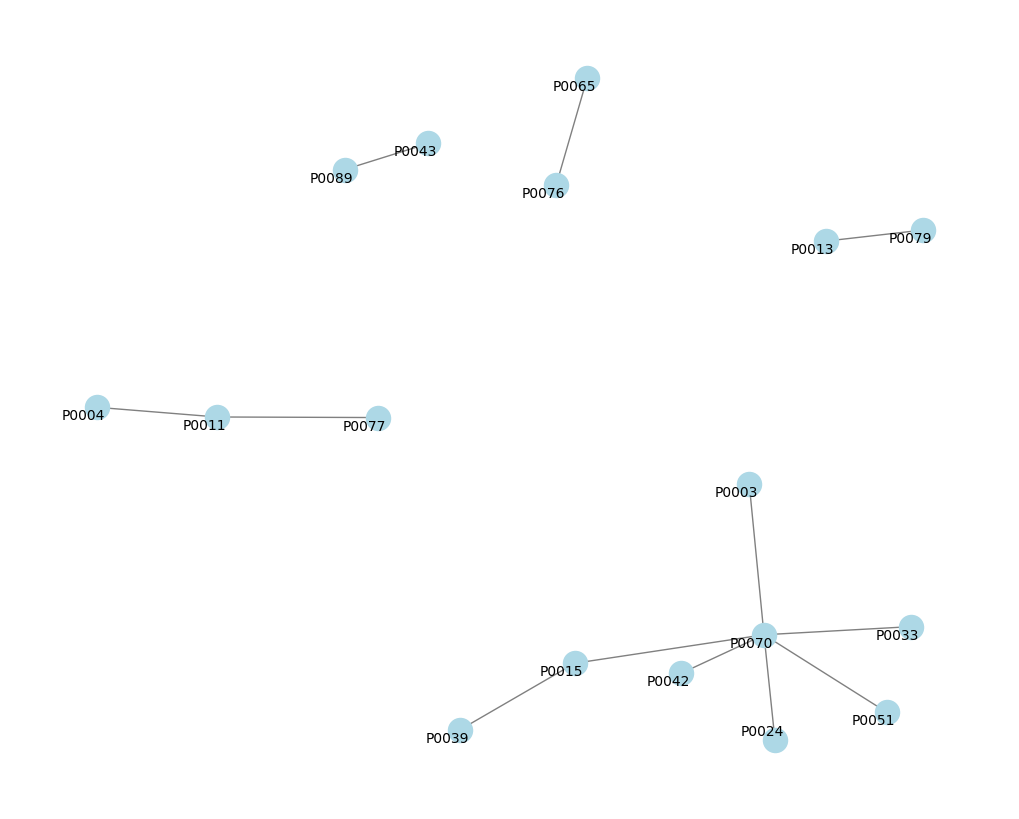

In [15]:
# Finding product bundles, then showing using a network diagram

# Making graph edges using the antecedents and consequents given by the Apriori algorithm
G = nx.from_pandas_edgelist(rules, 'antecedents', 'consequents', edge_attr=['lift'])  

# Convert frozenset to readable strings
labels = {}
for node in G.nodes():
    if isinstance(node, frozenset):
        labels[node] = ', '.join(node)  # Convert frozenset to a readable string
    else:
        labels[node] = str(node)  # Convert other types to string

# Compute layout with spacing
pos = nx.spring_layout(G, k=0.5, seed=42)

# Draw the graph, without labels for now
plt.figure(figsize=(10,8))  
nx.draw(G, pos, with_labels=False, node_color='lightblue', edge_color='gray')  

# Add labels with spacing
texts = []
for node, (x, y) in pos.items():
    text = plt.text(x, y, labels[node], fontsize=10, ha='center', va='center')
    texts.append(text)

adjust_text(texts)

plt.show()

## 📊 Part 4: Visualization
Steps:
- Plot user similarity heatmap
- Plot top frequent itemsets
- Visualize top recommendations

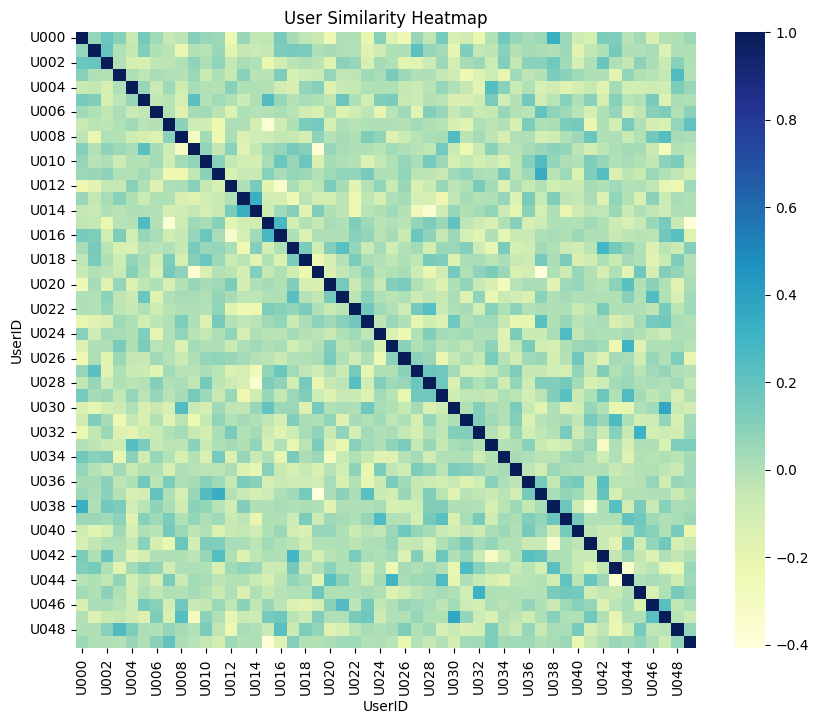

In [16]:
# Heatmap of user similarity
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, cmap='YlGnBu')
plt.title('User Similarity Heatmap')
plt.show()

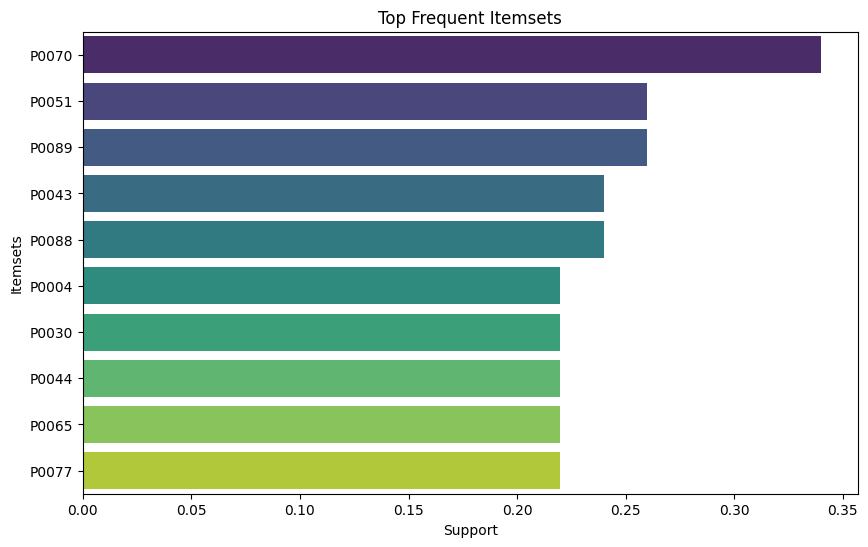

In [17]:
# Visualize frequent itemsets using bar charts
# Convert frozen sets to strings for visualization
frequent_itemsets['itemset'] = frequent_itemsets['itemsets'].apply(lambda x: ', '.join(list(x)))

# Sort and select top N itemsets, support being the frequency of the rule in the dataset
top_itemsets = frequent_itemsets.nlargest(10, 'support')

plt.figure(figsize=(10, 6))
sns.barplot(x='support', y='itemset', data=top_itemsets, hue='itemset', dodge=False, legend=False, palette='viridis')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.title('Top Frequent Itemsets')
plt.show()

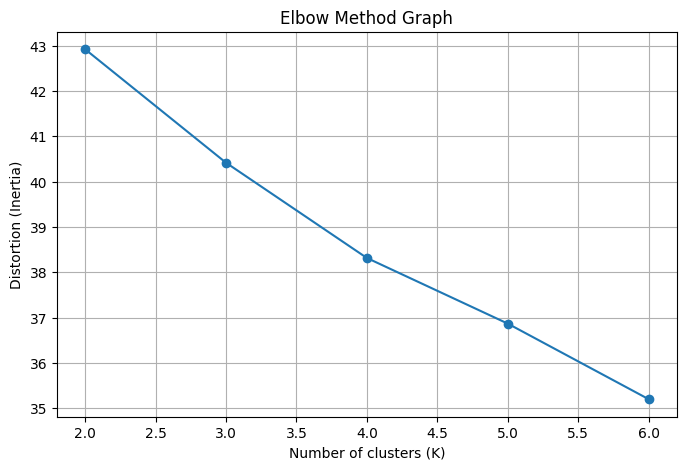

In [18]:
# Top-5 product recommendations for each user group.

# Step 1: Using Elbow Method to attempt to find the optimal K
scaler = MinMaxScaler()
distance_matrix = scaler.fit_transform(similarity_df.values)

distortions = []
silhouette_scores = []
K_range = range(2, 7) # ecommerce_user_data is a small dataset, so adjust K_range to 2-6 to avoid overfitting

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++', n_init=20) # init='k-means++',
    kmeans.fit(distance_matrix)
    distortions.append(kmeans.inertia_)
    score = silhouette_score(distance_matrix, kmeans.labels_)
    silhouette_scores.append(score)


# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, distortions, marker='o', linestyle='-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method Graph')
plt.grid(True)
plt.show()

# To me, the elbow is not obvious... we will use another metric to determine K

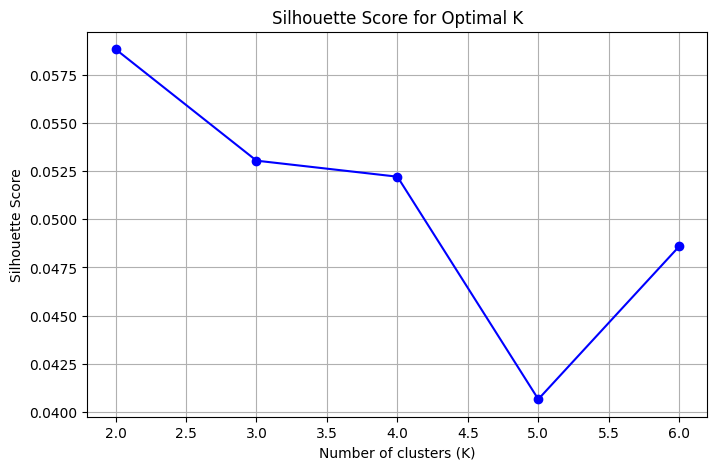

Optimal number of clusters (K) based on silhouette score: 2


In [19]:
# Plot the silhouette scores (a metric that helps us determine K)
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.grid(True)
plt.show()

# Find the optimal K (go to Step 2 and replace k with the optimal K)
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters (K) based on silhouette score: {optimal_k}")

In [20]:
# Apply K-Means clustering
k = 2  # Tune this based on the elbow method
kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++', n_init=20)
user_clusters = kmeans.fit_predict(distance_matrix)

# DataFrame that has columns UserID and Cluster
user_cluster_df = pd.DataFrame({'UserID': similarity_df.index, 'Cluster': user_clusters})
print(user_cluster_df.head())

  UserID  Cluster
0   U000        1
1   U001        1
2   U002        1
3   U003        0
4   U004        0


In [21]:
# Step 3: Make a list of users for each cluster
clustered_users = user_cluster_df.groupby('Cluster')['UserID'].apply(list)

# Print the clustered users
for cluster, users in clustered_users.items():
    print(f"Cluster {cluster}:")
    print(users)
    print("-" * 100)

Cluster 0:
['U003', 'U004', 'U005', 'U007', 'U008', 'U012', 'U013', 'U014', 'U015', 'U019', 'U020', 'U021', 'U023', 'U025', 'U026', 'U030', 'U032', 'U033', 'U036', 'U040', 'U041', 'U044', 'U046', 'U047', 'U048']
----------------------------------------------------------------------------------------------------
Cluster 1:
['U000', 'U001', 'U002', 'U006', 'U009', 'U010', 'U011', 'U016', 'U017', 'U018', 'U022', 'U024', 'U027', 'U028', 'U029', 'U031', 'U034', 'U035', 'U037', 'U038', 'U039', 'U042', 'U043', 'U045', 'U049']
----------------------------------------------------------------------------------------------------


In [ ]:
# Step 4: Compute the Top-5 product recommendations for each cluster

cluster_rec_prod = [] # A list of dictionnaries. Each dictionnary is tied to a cluster.

for cluster, users in clustered_users.items():
    cluster_dict = {}
    
    # For a user in a cluster
    # Based on the top 10 most similar users, find the top-5 recommended products
    for user in users:
        rec_prod = recommend_products(user, user_item_matrix_filled, similarity_df, 10)
        rec_prod = rec_prod.head(5)
        
        # We will not force the average ratings to be 5 yet...
        
        # rec_prod is a Series where index is productID and value is predicted rating
        # cluster_dict has a productID (key) and a list of predicted ratings (value)
        for product_id, predicted_rating in rec_prod.items():
            if product_id not in cluster_dict:
                cluster_dict[product_id] = {'predicted_ratings': []}
                
            cluster_dict[product_id]['predicted_ratings'].append(predicted_rating)
    
    # Calculate the average predicted rating for each product in the cluster_dict
    for product, details in cluster_dict.items():
        if details['predicted_ratings']:
            avg_rating = np.mean(details['predicted_ratings'])
        else:
            avg_rating = 0
        
        # Remove the list of predicted ratings (we only need the average)
        del cluster_dict[product]['predicted_ratings']
        
        cluster_dict[product] = avg_rating
    
    # Sort cluster_dict in DESC order based on average predicted rating
    cluster_dict = {k: v for k, v in sorted(cluster_dict.items(), key=lambda item: item[1], reverse=True)}
    
    # We will now force the average predicted ratings to be 5
    for product_id, avg_rating in cluster_dict.items():
        cluster_dict[product_id] = float(min(cluster_dict[product_id], 5))
    
    # Append dict to cluster_rec_prod
    cluster_rec_prod.append({cluster: cluster_dict})

{'P0008': np.float64(5.0), 'P0016': np.float64(5.0), 'P0095': np.float64(5.0), 'P0048': np.float64(5.0), 'P0035': np.float64(5.0), 'P0005': np.float64(5.0), 'P0017': np.float64(5.0), 'P0024': np.float64(5.0), 'P0061': np.float64(5.0), 'P0065': np.float64(5.0), 'P0083': np.float64(5.0), 'P0040': np.float64(5.000000000000001), 'P0011': np.float64(5.0), 'P0000': np.float64(5.0), 'P0045': np.float64(5.0), 'P0054': np.float64(5.0), 'P0041': np.float64(5.0), 'P0034': np.float64(5.0), 'P0049': np.float64(5.0), 'P0069': np.float64(5.0), 'P0032': np.float64(5.0), 'P0052': np.float64(5.0), 'P0038': np.float64(5.0), 'P0071': np.float64(5.0), 'P0079': np.float64(5.0), 'P0006': np.float64(5.0), 'P0088': np.float64(5.0), 'P0020': np.float64(5.0), 'P0068': np.float64(5.0), 'P0080': np.float64(5.0), 'P0007': np.float64(5.0), 'P0029': np.float64(5.0), 'P0092': np.float64(5.0), 'P0050': np.float64(5.0), 'P0044': np.float64(4.402281462675934), 'P0037': np.float64(5.0), 'P0039': np.float64(5.0), 'P0073': 

In [26]:
# Print the top 5 products in cluster_products. cluster_products is already sorted in DESC order
num_of_top_products = 5

for cluster_dict in cluster_rec_prod:
    # cluster_dict has key cluster_number and value product_rating_dict
    for cluster_number, product_rating_dict in cluster_dict.items():
        print(f"Cluster {cluster_number}:")
        count = 0
        
        for productID, avg_rating in product_rating_dict.items():
            if (count < num_of_top_products):
                print(f"Product ID: {productID} -- Average rating: {avg_rating}")
                count += 1

    print("-" * 100)

Cluster 0:
Product ID: P0040 -- Average rating: 5.0
Product ID: P0008 -- Average rating: 5.0
Product ID: P0016 -- Average rating: 5.0
Product ID: P0095 -- Average rating: 5.0
Product ID: P0048 -- Average rating: 5.0
----------------------------------------------------------------------------------------------------
Cluster 1:
Product ID: P0036 -- Average rating: 5.0
Product ID: P0049 -- Average rating: 5.0
Product ID: P0024 -- Average rating: 5.0
Product ID: P0078 -- Average rating: 5.0
Product ID: P0016 -- Average rating: 5.0
----------------------------------------------------------------------------------------------------


## 🧠 Part 5: Conceptual Questions
Answer the following questions in your report:
1. How does data sparsity affect performance?
2. What kinds of product bundles were discovered?
3. What improvements would you suggest for real-world deployment?